<a href="https://colab.research.google.com/github/blegried93/New-Projects/blob/main/XGBoost_RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Set plotting style
plt.style.use("ggplot")

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

print("Default setup loaded!")

Default setup loaded!


In [ ]:
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder as le
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier as xgbC
from xgboost import XGBRegressor as xgbR




In [ ]:
#creates a mechanism to import a csv file instead of a default dataset from scikit-learn

import csv

def upload_csv(file_path, key_column, usecols = None):
    """
    Uploads and processes a CSV file, converting it to a dictionary.

    Args:
        file_path (str): The path to the CSV file.
        key_column (str): The name of the column to use as keys in the dictionary.

    Returns:
        dict: A dictionary representing the rows in the CSV file,
              with the specified key column as keys and the rest of
              the row data as values.
              Returns an empty dictionary if an error occurs.
    """
    data_dict = {}  # Initialize an empty dictionary to store the data
    try:
        with open(file_path, 'r') as file:
            csv_reader = csv.DictReader(file)
            # If usecols is specified, filter the columns in the reader
            if usecols:
                csv_reader = (dict((k, v) for k, v in row.items() if k in usecols)
                               for row in csv_reader)
            for row in csv_reader:
                # Check if fitness is numeric, skip if not
                try:
                    fitness_value = float(row['fitness'])  # Attempt conversion to float
                except ValueError:
                    continue  # Skip this row if conversion fails

                key = row[key_column]  # Get the value from the key column
                # Convert all values in the row to numeric if possible
                for k, v in row.items():
                    try:
                        row[k] = pd.to_numeric(v, errors='ignore')  # ignore instead of coercing values that do not convert to numeric
                    except ValueError:
                        pass  # Skip if conversion fails
                data_dict[key] = row  # Add the row to the dictionary using the key
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")
    return data_dict

In [ ]:
#from sklearn.datasets import fetch_california_housing

#data = fetch_california_housing()
ColNames = ['fitness', 'TupleScore1', 'TupleScore2','TupleScore3','TupleScore4','TupleScore5']
data = upload_csv("input_reads.csv", "fitness", usecols=ColNames)
#df = pd.DataFrame(data.data, columns=data.feature_names)
df = pd.DataFrame(data) # Change this line to directly create the DataFrame from the dictionary.
df = df.T
#df['Fitness'] = data.target

df.head()


<ipython-input-25-47f0460ef2e0>:38: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  row[k] = pd.to_numeric(v, errors='ignore')  # ignore instead of coercing values that do not convert to numeric


,fitness,TupleScore1,TupleScore2,TupleScore3,TupleScore4,TupleScore5
-0.12748903,-0.127489,2.0,3.0,2.0,0.0,3.0
0.00614505,0.006145,0.0,0.0,2.0,0.0,3.0
-0.094612749,-0.094613,0.0,3.0,2.0,0.0,3.0
-0.035709912,-0.035710,2.0,3.0,2.0,0.0,3.0
-0.045910684,-0.045911,0.0,0.0,2.0,0.0,3.0


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score # Import mean_squared_error and r2_score

# Function to train and save predictions
#Test_size is the complement of the training_size
def train_and_save_predictions(test_size):
    # Load data
    #data = fetch_california_housing()
    #df = pd.DataFrame(data.data, columns=data.feature_names)
    #df['MedHouseVal'] = data.target

    # Split data
    X_train, X_test, y_train, y_test = tts(df.drop('fitness', axis=1), df['fitness'],
                                            test_size=test_size, random_state=42)

    # Train model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Make predictions
    predictions = model.predict(X_test)
    comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
    error1 = compute_error_metrics(y_test,predictions)

    # Create the 'data' directory if it doesn't exist
    output_dir = '../data'  # Directory for saving predictions
    os.makedirs(output_dir, exist_ok=True)

    # Save results
    filename = os.path.join(output_dir, f'predictions_testsize_{test_size}.csv')
    comparison_df.to_csv(filename, index=False)
    print(f"mse, rmse, r2 are {error1}")
    print(f"Predictions saved to {filename}")

if __name__ == "__main__":
    train_and_save_predictions(test_size)


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:seq: object, TupleScore1: object, TupleScore2: object, TupleScore3: object, TupleScore4: object, TupleScore5: object

In [ ]:
#prints predictions from training
def print_predictions(test_size):
    filename = f'../data/predictions_testsize_{test_size}.csv'
    df = pd.read_csv(filename)
    print(f"\nPredictions for test_size={test_size}:\n")
    print(df.head())

if __name__ == "__main__":
    print_predictions(test_size)



FileNotFoundError: [Errno 2] No such file or directory: '../data/predictions_testsize_0.1.csv'

In [ ]:

def plot_results(test_size):
    filename = f'../data/predictions_testsize_{test_size}.csv'
    df = pd.read_csv(filename)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(df['Actual'], df['Predicted'], alpha=0.5)
    plt.plot([df['Actual'].min(), df['Actual'].max()],
             [df['Actual'].min(), df['Actual'].max()], color='red')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values (test_size={test_size})')
    plt.grid()

    # Save plot
    plt.show()
    plot_filename = f'../data/plot_testsize_{test_size}.png'
    plt.savefig(plot_filename)
    plt.close()
    print(f"Plot saved to {plot_filename}")

if __name__ == "__main__":
    plot_results(test_size)


FileNotFoundError: [Errno 2] No such file or directory: '../data/predictions_testsize_0.1.csv'

In [ ]:
def compute_error_metrics(y_true,y_pred):
  mse = mean_squared_error(y_true,y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true,y_pred)

  return mse, rmse, r2


Running experiment with test_size=0.1...

mse, rmse, r2 are (0.013138554781467178, 0.11462353502430109, 0.40047763349512766)
Predictions saved to ../data/predictions_testsize_0.1.csv

Predictions for test_size=0.1:

     Actual  Predicted
0 -0.038014  -0.110719
1 -0.148014  -0.261490
2 -0.234501  -0.217798
3 -0.277861  -0.264817
4 -0.164877  -0.351132


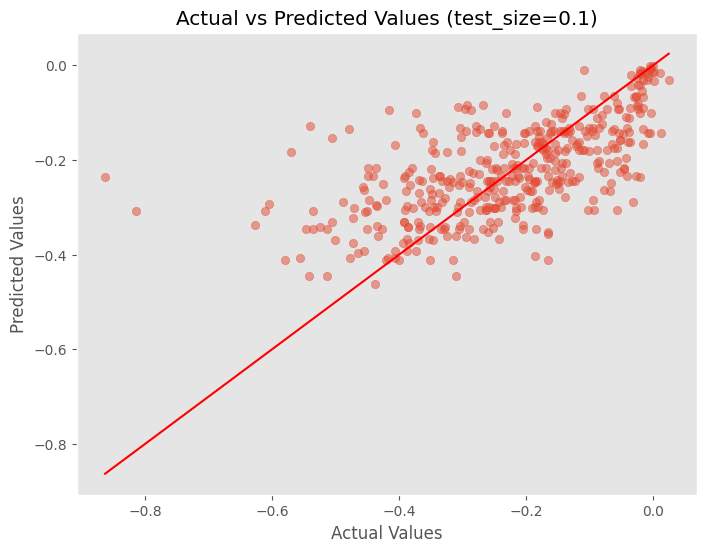

Plot saved to ../data/plot_testsize_0.1.png

Running experiment with test_size=0.5...

mse, rmse, r2 are (0.01181341083969382, 0.10868951577633336, 0.41433301816502033)
Predictions saved to ../data/predictions_testsize_0.5.csv

Predictions for test_size=0.5:

     Actual  Predicted
0 -0.038014  -0.153917
1 -0.148014  -0.244932
2 -0.234501  -0.195925
3 -0.277861  -0.250268
4 -0.164877  -0.330306


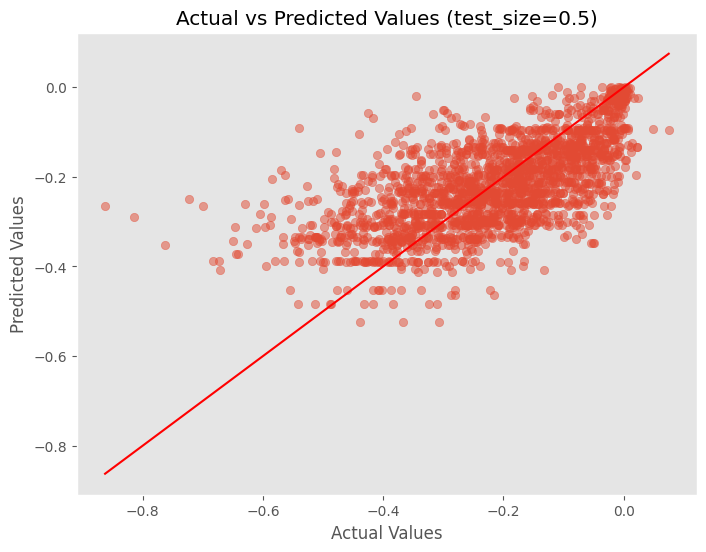

Plot saved to ../data/plot_testsize_0.5.png

Running experiment with test_size=0.9...

mse, rmse, r2 are (0.013809267732703115, 0.11751284071412416, 0.29167885938361404)
Predictions saved to ../data/predictions_testsize_0.9.csv

Predictions for test_size=0.9:

     Actual  Predicted
0 -0.038014  -0.218120
1 -0.148014  -0.239644
2 -0.234501  -0.237694
3 -0.277861  -0.271262
4 -0.164877  -0.318622


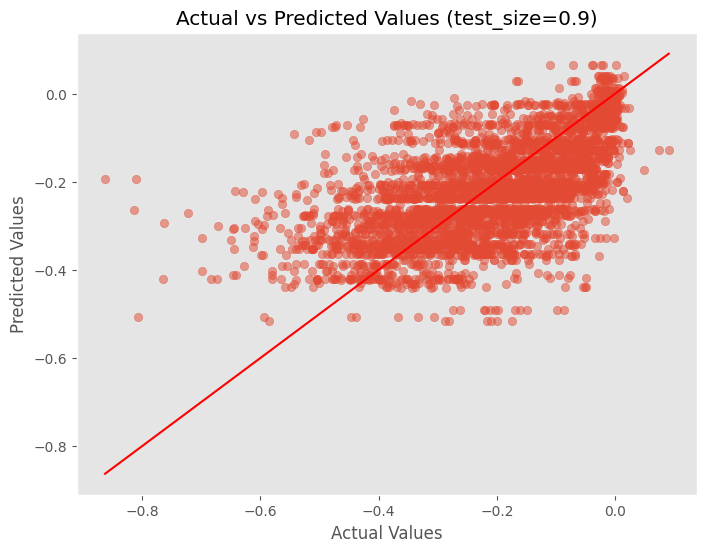

Plot saved to ../data/plot_testsize_0.9.png


In [ ]:
import subprocess

#Driver file for the previous 3 steps.
def run_experiment(test_size):
    print(f"\nRunning experiment with test_size={test_size}...\n")
    train_and_save_predictions(test_size)
    print_predictions(test_size)
    plot_results(test_size)

if __name__ == "__main__":
    test_sizes = [0.1, 0.5, 0.9]
    for test_size in test_sizes:
        run_experiment(test_size)